In [62]:
import numpy as np
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time, sleep

from utils import *
from jigsaws_utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *
from physionet_pytorch.utils.get_data import *

import warnings
warnings.simplefilter('ignore', category=np.ComplexWarning)

def cross_predict(model, gram_matrix, y, nsplits=5, d_transform=None):
    nsample = len(y)
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    all_preds = np.array([])
    all_true = np.array([])
    train_accs = np.zeros(nsplits)
    for i, (train_index, test_index) in enumerate(kfolder.split(y, groups=groups)):
        if d_transform is not None:
            gram_train = d_transform(gram_matrix[train_index, :][:, train_index])
            gram_test = d_transform(gram_matrix[test_index, :][:, train_index])
        else:
            gram_train = gram_matrix[train_index, :][:, train_index]
            gram_test = gram_matrix[test_index, :][:, train_index]

        # Predict
        model.fit(gram_train, y[train_index])
        train_accs[i] = np.mean(y[train_index] == model.predict(gram_train))
        preds = model.predict(gram_test)
        all_preds = np.append(all_preds, preds)
        all_true = np.append(all_true, y[test_index])

    test_acc = accuracy_score(all_preds, all_true)
    return np.mean(train_accs), test_acc, all_preds, all_true

## Evaluation for 2 classes setup

#### Load data and setup

In [2]:
data_2class = np.load('data/physionetmmmi/2class.npz')
X, y = np.transpose(data_2class['X'], [0,2,1]), data_2class['y']
nsample = len(y)
print(X.shape, y.shape)

ks = np.arange(1, 8)
gammas = np.logspace(-10, -5, base=2, num=10)
ncomp = 10

(4410, 480, 64) (4410,)


#### Create needed data structures

In [3]:
import os

filename_X_ma = 'data_generated/physionet/2class/X_matrices.pkl'
if os.path.isfile(filename_X_ma):
    print('Loading X\'s matrices from file')
    X_ma = pickle.load(open(filename_X_ma, 'rb'))
else:
    print('Creating X\'s matrices')
    X_ma = []
    for seq in X:
        compression_model = custom_pca(ncomp)
        compression_model.fit(seq)
        seq_enc, _ = compression_model.encode(seq)
        A = np.linalg.pinv(seq_enc[:-1])@seq_enc[1:]

        X_ma.append((compression_model, A))
    pickle.dump(X_ma, open(filename_X_ma, 'wb'))

dists = [martin_dist, frob_dist]
dist_names = ['martin', 'frob']
filename_gram_base = 'data/physionet/2class/gram_matrix_{:s}.pkl'
gram_matrices = {}
for dist, dist_name in zip(dists, dist_names):
    filename_gram = filename_gram_base.format(dist_name)
    if os.path.isfile(filename_gram):
        print('Loading gram matrix from file for %s distance' % dist_name)
        full_gram_matrix = pickle.load(open(filename_gram, 'rb'))
        if np.any(~np.isfinite(full_gram_matrix)):
            for i, j in np.where(np.isnan(full_gram_matrix)):
                print(f'Replacing element [{i},{j}] with 0')
                full_gram_matrix[i,j] = 0
        gram_matrices[dist_name] = full_gram_matrix
    else:
        start = time()
        full_gram_matrix = np.zeros((len(X), len(X)))
        print('Creating gram matrix')
        for i, mi in enumerate(X_ma):
            if i % 50 == 0:
                print(f'{i+1}/{len(X_ma)} ({sec2string(time()-start)})')
            for j, mj in enumerate(X_ma):
                if i > j:
                    full_gram_matrix[i,j] = full_gram_matrix[j,i]
                else:
                    # Check: negative values appear when computing distance. For the moment round them to zero
                    # while verifying they are all small enough
                    dist_curr = dist(mi, mj)
                    if dist_curr < -1e-13:
                        raise ValueError('Negative values should not appear.')
                full_gram_matrix[i,j] = dist_curr
        full_gram_matrix[full_gram_matrix < 0] = 0
        pickle.dump(full_gram_matrix, open(filename_gram, 'wb'))
        gram_matrices[dist_name] = full_gram_matrix

Loading X's matrices from file
Loading gram matrix from file for martin distance
Loading gram matrix from file for frob distance


#### Evaluate using 5-fold cross validation accross all samples

In [32]:
evaluation_baseline = {}
evaluation_baseline_filename = 'data_generated/physionet/2class/evaluation_baseline.pkl'

start = time()
for dist, dist_name in zip(dists, dist_names):
    full_gram_matrix = gram_matrices[dist_name]
                                       
    # Evaluation using KNN
    train_accs = np.zeros(len(ks))
    test_accs = np.zeros(len(ks))
    for ki, k in enumerate(ks):
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=-1)
        train_acc, test_acc, _, _ = cross_predict(knn, full_gram_matrix, y)
        train_accs[ki] = train_acc
        test_accs[ki] = test_acc
        print(f'(KNN, {dist_name}, {k}) -> {train_acc:.4} {test_acc:.4}')
    evaluation_baseline[f'KNN-{dist_name}'] = {'ks': ks,
                                               'train_accs': train_accs,
                                              'test_accs': test_accs}

    # Evaluation using SVM
    train_accs = np.zeros(len(gammas))
    test_accs = np.zeros(len(gammas))
    svm_model = SVC()
    for gammai, gamma in enumerate(gammas):
        train_acc, test_acc, _, _ = cross_predict(svm_model, full_gram_matrix, y, d_transform=lambda x: np.exp(-gamma*x))
        train_accs[gammai] = train_acc
        test_accs[gammai] = test_acc
        print(f'(SVM, {dist_name}, {gamma:.5}) -> {train_acc:.4} {test_acc:.4}')
    evaluation_baseline[f'SVM-{dist_name}'] = {'gammas': gammas,
                                               'train_accs': train_accs,
                                              'test_accs': test_accs}
pickle.dump(evaluation_baseline, open(evaluation_baseline_filename, 'wb'))

(KNN, martin, 1) -> 1.0 0.4982
(KNN, martin, 2) -> 0.7502 0.4984
(KNN, martin, 3) -> 0.7481 0.507
(KNN, martin, 4) -> 0.6849 0.5052
(KNN, martin, 5) -> 0.6821 0.5054
(KNN, martin, 6) -> 0.6523 0.4973
(KNN, martin, 7) -> 0.65 0.5054
(SVM, martin, 0.00097656) -> 0.8412 0.5299
(SVM, martin, 0.0014353) -> 0.8409 0.5306
(SVM, martin, 0.0021095) -> 0.8407 0.5315
(SVM, martin, 0.0031004) -> 0.8399 0.5308
(SVM, martin, 0.0045568) -> 0.8383 0.5313
(SVM, martin, 0.0066972) -> 0.8376 0.5311
(SVM, martin, 0.0098431) -> 0.8344 0.5329
(SVM, martin, 0.014467) -> 0.8319 0.5324
(SVM, martin, 0.021262) -> 0.8274 0.5354
(SVM, martin, 0.03125) -> 0.8214 0.5322
(KNN, frob, 1) -> 1.0 0.5116
(KNN, frob, 2) -> 0.7486 0.5147
(KNN, frob, 3) -> 0.7649 0.5331
(KNN, frob, 4) -> 0.6893 0.5277
(KNN, frob, 5) -> 0.6981 0.5286
(KNN, frob, 6) -> 0.6705 0.524
(KNN, frob, 7) -> 0.6761 0.537
(SVM, frob, 0.00097656) -> 0.6029 0.5601
(SVM, frob, 0.0014353) -> 0.603 0.5601
(SVM, frob, 0.0021095) -> 0.6034 0.5594
(SVM, frob, 

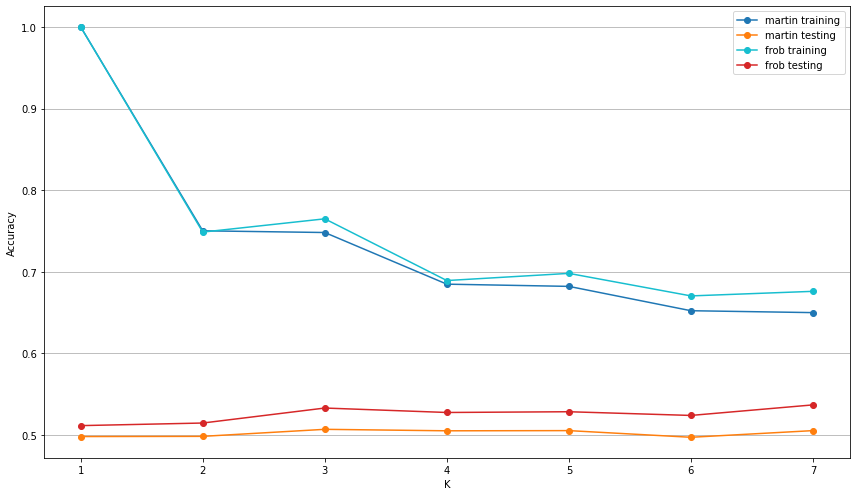

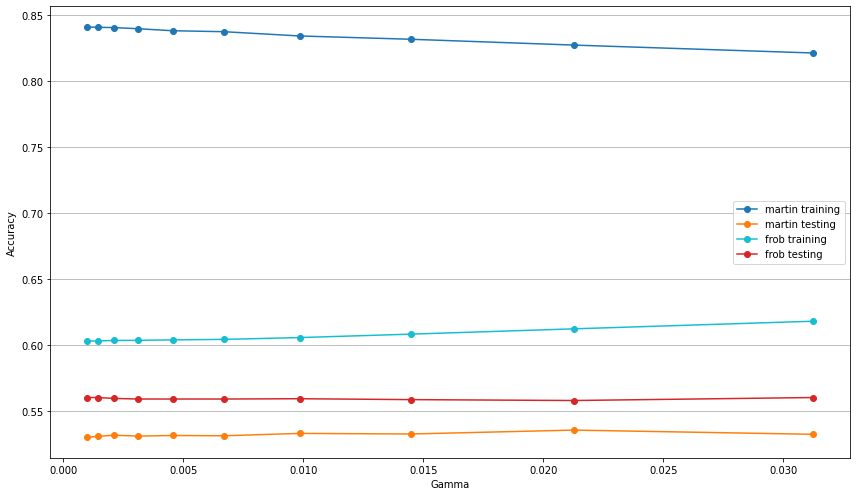

In [33]:
evaluation_baseline = pickle.load(open(evaluation_baseline_filename, 'rb'))

colors = ['tab:blue', 'tab:cyan', 'tab:orange', 'tab:red']
size=(12,7)

# KNN
plt.figure(figsize=size)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(axis='y')
for di, dist_name in enumerate(dist_names):
    curr = evaluation_baseline[f'KNN-{dist_name}']
    plt.plot(curr['ks'], curr['train_accs'],
            color=colors[di], marker='o', label=f'{dist_name} training')
    plt.plot(curr['ks'], curr['test_accs'],
            color=colors[di+2], marker='o', label=f'{dist_name} testing')
plt.legend()
plt.tight_layout()
#plt.savefig('data_generated/physionet/2class/???')
plt.show()

# SVM
plt.figure(figsize=size)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.grid(axis='y')
for di, dist_name in enumerate(dist_names):
    curr = evaluation_baseline[f'SVM-{dist_name}']
    plt.plot(curr['gammas'], curr['train_accs'],
            color=colors[di], marker='o', label=f'{dist_name} training')
    plt.plot(curr['gammas'], curr['test_accs'],
            color=colors[di+2], marker='o', label=f'{dist_name} testing')
plt.legend()
plt.tight_layout()
#plt.savefig('data_generated/physionet/2class/???')
_ = plt.show()

#### Evaluate separating the subjects

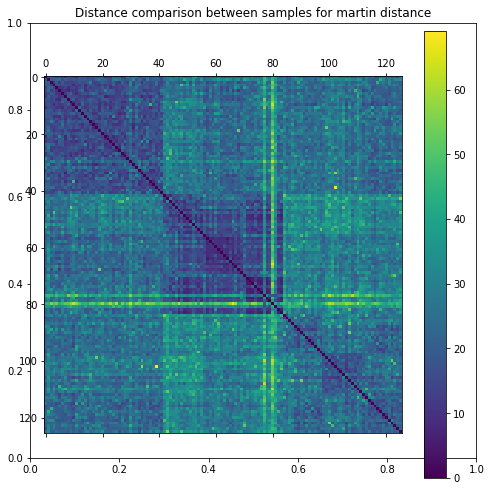

In [41]:
nsubjects = 105
nsample_per_sub = nsample / nsubjects
if not nsample_per_sub.is_integer():
    print('The number of sample per subject is not an integer!')
nsample_per_sub = int(nsample_per_sub)

plt.figure(figsize=(8,8))
plt.title('Distance comparison between samples for martin distance')
plt.matshow(gram_matrices['martin'][:nsample_per_sub*3, :nsample_per_sub*3], fignum=1)
_ = plt.colorbar()

In [61]:
evaluation_within_subjects = {}
subject_accuracies = {}

X_sub = np.array_split(X_ma, nsubjects)
dist_name = 'martin'
dist_gram = gram_matrices[dist_name]
gram_sub = np.array_split(gram_matrices[dist_name], nsubjects)

# KNN
acc_per_sub_train = np.zeros((nsubjects, len(ks)))
acc_per_sub_test = np.zeros((nsubjects, len(ks)))
for ki, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=-1)
    for si, s in enumerate(range(nsubjects)):
        sample_sub = X_sub[si]
        start_i, end_i = si*nsample_per_sub, (si+1)*nsample_per_sub
        gram_sub = dist_gram[start_i:end_i, start_i:end_i]
        train_acc, test_acc, _, _ = cross_predict(knn, gram_sub, y[start_i:end_i])
        acc_per_sub_train[si, ki] = train_acc
        acc_per_sub_test[si, ki] = test_acc
evaluation_within_subjects['KNN'] = {'ks': ks,
                                    'train_acc_per_sub': acc_per_sub_train,
                                    'test_acc_per_sub': acc_per_sub_test}
        
# SVM        
acc_per_sub_train = np.zeros((nsubjects, len(gammas)))
acc_per_sub_test = np.zeros((nsubjects, len(gammas)))
svm_model = SVC()
for gammai, gamma in enumerate(gammas):
    for si, s in enumerate(range(nsubjects)):
        sample_sub = X_sub[si]
        start_i, end_i = si*nsample_per_sub, (si+1)*nsample_per_sub
        gram_sub = dist_gram[start_i:end_i, start_i:end_i]
        train_acc, test_acc, _, _ = cross_predict(svm_model, gram_sub, y[start_i:end_i], d_transform=lambda x: np.exp(-gamma*x))
        acc_per_sub_train[si, gammai] = train_acc
        acc_per_sub_test[si, gammai] = test_acc
evaluation_within_subjects['SVM'] = {'gammas': gammas,
                                    'train_acc_per_sub': acc_per_sub_train,
                                    'test_acc_per_sub': acc_per_sub_test}

/home/jules/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


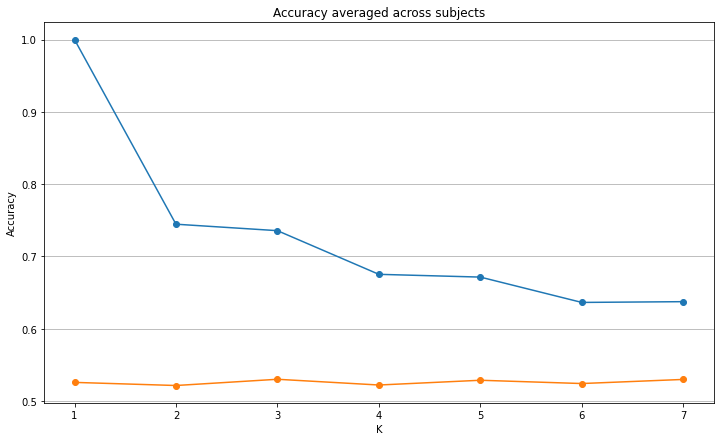

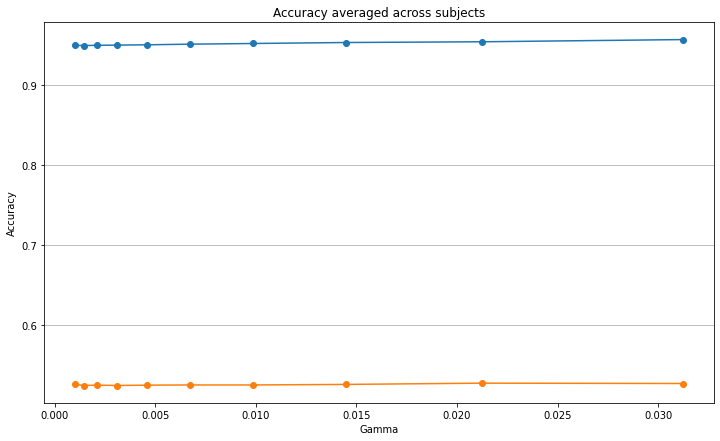

In [68]:
plt.figure(figsize=size)
plt.title('Accuracy averaged across subjects')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.xlabel('K')

train_accs = evaluation_within_subjects['KNN']['train_acc_per_sub']
test_accs = evaluation_within_subjects['KNN']['test_acc_per_sub']
plt.plot(ks, np.mean(train_accs, axis=0), marker='o', label='Training')
_ = plt.plot(ks, np.mean(test_accs, axis=0), marker='o', label='Testing')
    
    
plt.figure(figsize=size)
plt.title('Accuracy averaged across subjects')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.xlabel('Gamma')

train_accs = evaluation_within_subjects['SVM']['train_acc_per_sub']
test_accs = evaluation_within_subjects['SVM']['test_acc_per_sub']
plt.plot(gammas, np.mean(train_accs, axis=0), marker='o', label='Training')
_ = plt.plot(gammas, np.mean(test_accs, axis=0), marker='o', label='Testing')


## Misc

In [19]:
# Pick 10 random of each class
c0 = np.random.choice(np.arange(len(X_ma))[y==0], size=10, replace=False)
c1 = np.random.choice(np.arange(len(X_ma))[y==1], size=10, replace=False)
print('Indices class 0:', c0)
print('Indices class 1:', c1)
print()

diff = []
for i in c0:
    for j in c1:
        diff.append(full_gram_matrix[i,j])
diff = np.round(np.unique(diff), 2)
print(diff)
print()

same0 = []
for i in c0:
    for j in c0:
        same0.append(full_gram_matrix[i,j])
same0 = np.round(np.unique(same0), 2)
print(same0)
print()

same1 = []
for i in c1:
    for j in c1:
        same1.append(full_gram_matrix[i,j])
same1 = np.round(np.unique(same1), 2)
print(same1)

Indices class 0: [3627 3246  318  424 3307  443 1759 2505 2030 2458]
Indices class 1: [3672 4370 1697 2332 1993 2262  957 3505  516 3950]
[19.91 20.63 21.77 22.67 23.24 23.47 24.14 24.41 25.47 26.55 26.89 27.35
 27.39 27.63 28.59 28.77 28.84 29.42 29.48 29.65 30.07 30.18 30.41 30.57
 31.2  32.42 32.51 32.83 33.16 33.27 34.31 34.75 34.9  34.9  35.08 35.18
 35.24 35.3  35.69 36.09 36.37 36.55 36.72 36.79 36.85 37.05 37.07 37.31
 37.69 37.69 37.96 38.08 38.22 38.38 38.94 38.95 39.36 39.45 39.78 40.71
 41.36 41.88 42.42 42.69 42.75 42.97 43.32 46.69 46.89 46.95 47.54 47.86
 48.36 48.67 49.31 49.37 49.56 49.58 49.74 50.28 50.39 50.86 51.69 51.72
 52.02 52.06 53.22 53.83 54.16 54.28 55.66 55.84 58.24 59.72 59.88 60.79
 62.59 62.86 71.09 88.49]

[ 0.    0.    0.    0.    0.    0.    0.   22.4  26.72 27.81 28.01 28.08
 28.86 29.43 29.82 30.13 30.58 31.27 33.02 33.26 33.34 33.5  34.35 34.53
 36.17 36.49 36.74 36.93 37.2  37.61 37.98 38.2  38.58 39.2  39.44 39.63
 40.78 41.8  41.93 42.07 43.15 4